In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
images_path = Path('/Users/chase.bergman/Desktop/Capstone/archive/images')
anno_path = Path('/Users/chase.bergman/Desktop/Capstone/archive/annotations')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [88]:
df_train = generate_train_df(anno_path)

In [89]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [90]:
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/Users/chase.bergman/Desktop/Capstone/archive/...,300,400,0,98,140,139,182
1,/Users/chase.bergman/Desktop/Capstone/archive/...,300,400,0,136,92,177,135
2,/Users/chase.bergman/Desktop/Capstone/archive/...,300,400,1,61,140,146,227
3,/Users/chase.bergman/Desktop/Capstone/archive/...,300,400,0,115,169,149,205
4,/Users/chase.bergman/Desktop/Capstone/archive/...,300,400,0,89,201,133,245


In [91]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [92]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [93]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)



In [94]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road_signs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/var/folders/53/2643vxbs37s2fd5kw9ql_j980000gp/T/ipykernel_9223/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


In [95]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)
print(im)

(400, 300, 3)
[[[215 174  99]
  [217 173 101]
  [217 173 101]
  ...
  [225 181 110]
  [225 181 110]
  [225 179 112]]

 [[216 174  99]
  [217 173 101]
  [217 173 101]
  ...
  [224 180 109]
  [224 180 110]
  [226 180 113]]

 [[216 174 100]
  [217 173 101]
  [217 173 101]
  ...
  [224 179 109]
  [223 179 109]
  [225 179 112]]

 ...

 [[204 222 197]
  [140 155 134]
  [120 131 116]
  ...
  [140 147 132]
  [144 151 136]
  [147 155 138]]

 [[198 218 193]
  [132 148 127]
  [111 121 106]
  ...
  [105 110  95]
  [154 159 144]
  [170 176 159]]

 [[197 218 193]
  [126 143 122]
  [ 98 107  90]
  ...
  [113 119 102]
  [137 143 126]
  [172 179 159]]]


/var/folders/53/2643vxbs37s2fd5kw9ql_j980000gp/T/ipykernel_9223/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


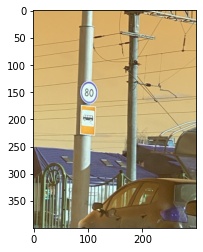

In [96]:
Y = create_mask(bb, im)
mask_to_bb(Y)

plt.imshow(im)

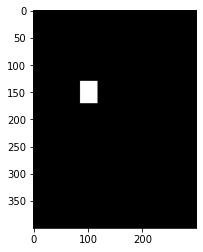

In [97]:
plt.imshow(Y, cmap='gray')

In [98]:
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [99]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [100]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

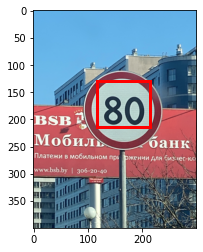

In [225]:
im = cv2.imread(str(df_train.values[60][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[21][9])